<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Stacked autoencoders<a id="top"></a>

<i><small>Authors: Alberto Díaz Álvarez and Félix José Fuentes Hurtado<br>Last update: 2023-10-02</small></i></div>

***

## Introducción

En la literatura existen diferentes arquitecturas denominadas **stacked autoencoders**. En este notebook desarrollaremos un ejemplo donde el concepto se refiere a aquellos *autoencoders* cuyos *encoder* y *decoder* están compuestos por varias capas ocultas antes de conectarse al espacio latente.

Otra versión ampliamente empleada de **stacked autoencoders** es aquella en la que lo que se apilan son los propios autoencoders, como muestra la imagen:

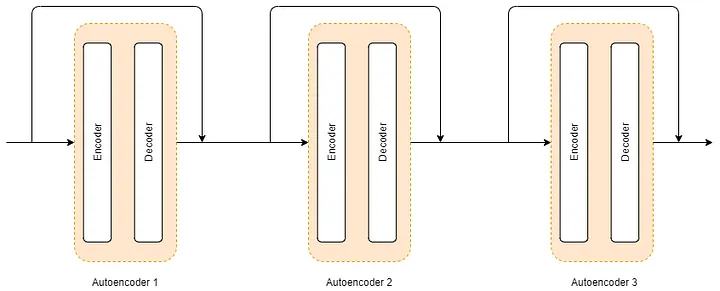

Por simplicidad, veremos el primer caso.

## Objetivos

Utilizaremos el conjunto de datos FashionMNIST, que contiene imágenes de diversas prendas de vestir, para entrenar nuestro *stacked autoencoder*. El objetivo es entrenar el modelo para que reconstruya las imágenes con la menor pérdida de información posible.

Para hacerlo más interesante, haremos uso de la técnica llamada "tie weights" para acelerar el entrenamiento de nuestro modelo. Empecemos.

## Librerías y configuración

A continuación importaremos las librerías que se utilizarán a lo largo del cuaderno.

In [ ]:
import itertools
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [ ]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Obteniendo el dataset

Esta vez utilizaremos el `FashionMNIST` en lugar del `MNIST` básico. Este conjunto de datos es una colección de 70.000 imágenes en escala de grises de prendas de vestir, de las que 60.000 se utilizan para el entrenamiento y 10.000 para las pruebas. Cada imagen tiene un tamaño de 28x28 píxeles y pertenece a una de 10 clases.

Se trata de un sustituto más exigente del conjunto de datos MNIST original, diseñado para tener propiedades similares a las del conjunto de datos MNIST, como estar bien equilibrado y ser de fácil acceso, pero con más complejidad y variedad en las imágenes.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255, x_test / 255

print(f'Training shape: {x_train.shape} input, {y_train.shape} output')
print(f'Test shape:     {x_test.shape} input, {y_test.shape} output')

4422102/4422102 [==============================] - 0s 0us/step
Training shape: (60000, 28, 28) input, (60000,) output
Test shape:     (10000, 28, 28) input, (10000,) output


## La técnica de "atar pesos" (*tie weights*)

Es una técnica utilizada para reducir el número de parámetros del modelo. En un *autoencoder* tradicional, hay dos conjuntos de pesos: los pesos del codificador y los pesos del decodificador. Al vincular los pesos, los **pesos del decodificador se limitan a ser iguales a la transposición de los pesos del codificador**.

<small>NOTA: Si te estás preguntando por qué transpuesta y no inversa, entra aquí: https://stats.stackexchange.com/questions/489429/why-are-the-tied-weights-in-autoencoders-transposed-and-not-inverted.</samll>

Esto significa que los pesos utilizados para reconstruir la entrada original son los mismos pesos utilizados para comprimir la entrada, lo que reduce el número de parámetros en el modelo (ayudando así a prevenir el sobreajuste y mejorando la generalización).

Estamos utilizando capas `Dense` para nuestros componentes codificador y decodificador, pero no existen capas transpuestas `Dense` en la librería Keras. Por lo tanto, crearemos una capa personalizada que reproducirá este comportamiento en nuestros modelos.

Primero, la implementación de la clase `TransposedDense`.

In [ ]:
class TransposedDense(tf.keras.layers.Layer):
    def __init__(self, from_layer, activation=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.from_layer = from_layer
        activation = activation or self.from_layer.activation
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(
            shape=self.from_layer.input_shape[-1],
            initializer='zeros',
        )
        return super().build(batch_input_shape)

    def call(self, x):
        z = tf.matmul(x, self.from_layer.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

**Pregunta:** Lee atentamente el código de la implementación de la capa `TransposedDense` y trata de averiguar y entender qué es lo que hace. Después, describe brevemente lo que hayas entendido.

**Respuesta:**

En este código, `TransposedDense` es una capa personalizada que toma otra capa (`from_layer`) como argumento. El método `build` establece el kernel y las `bias`(es decir, los pesos y sesgos) de esta capa para que sea la transposición de los pesos de la capa `from_layer`.

El método `call` define cómo calcular la salida de la capa dada la entrada, que en este caso es mediante la multiplicación matricial de `x` por la transpuesta de los pesos de la capa a la que está "atada". Después, le suma el término de `bias`.

Tened en cuenta que no siempre es necesario vincular los pesos y que, en algunos casos, puede no ser beneficioso.
Depende de la arquitectura y el problema concretos.

Ahora creamos la clase `StackedAutoencoder`.

In [ ]:
class StackedAutoencoder(tf.keras.models.Model):
    """Represents a stacked autoencoder."""

    def __init__(self, input_dim, layers, output_activation, name=None, *args, **kwargs):
        super().__init__(*args, name=name, **kwargs)

        # We calculate sizes and shapes of inputs, outputs and latent spaces
        flatten_dim = None
        if isinstance(input_dim, (list, tuple)):
            flatten_dim = math.prod(input_dim)
        elif isinstance(input_dim, int):
            flatten_dim = input_dim
            input_dim = (input_dim,)
        else:
            raise ValueError('Argument input_dim must be a tuple or an int')

        # Encoder definition: Connection between input and latent space
        encoder_layers = [
            tf.keras.layers.Dense(units, activation=tf.keras.layers.LeakyReLU(0.2))
            for units in layers
        ]
        self.encoder = tf.keras.Sequential([tf.keras.layers.Flatten()], name='Encoder')
        for dense in encoder_layers:
            self.encoder.add(dense)

        # Decoder definition: Connection between latent space and output
        self.decoder = tf.keras.Sequential([
            TransposedDense(dense) for dense in reversed(encoder_layers[1:])
        ], name='Decoder')
        self.decoder.add(TransposedDense(encoder_layers[0], output_activation))
        self.decoder.add(tf.keras.layers.Reshape(input_dim))

        # Weights construction (just to have summary model's method working)
        self.build((None, *input_dim))

    def call(self, x):
        return self.decoder(self.encoder(x))

Como vemos, hemos creado un codificador "reflejado" como el decodificador. Sin embargo, la última capa utiliza una función de activación diferente porque corresponde a la salida de nuestra red y, por tanto, los valores deben estar en el intervalo [0, 1].

In [ ]:
sae = StackedAutoencoder(
    input_dim=(28, 28),
    layers=[64, 32,],
    output_activation='sigmoid',
    name='Stacked')
sae.encoder.summary()
sae.decoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
Total params: 52320 (204.38 KB)
Trainable params: 52320 (204.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transposed_dense (Transpos  (None, 64)                2144      
 edDense)                                                        
    

Bien, ahora vamos a entrenar nuestro autoencoder apilado con el conjunto de entrenamiento:

In [ ]:
sae.compile(loss='binary_crossentropy', optimizer='adam')
history = sae.fit(x_train, x_train, epochs=100)

Epoch 1/100
1875/1875 [==============================] - 17s 5ms/step - loss: 0.3158
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2892
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2846
Epoch 4/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2821
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2806
Epoch 6/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2796
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2788
Epoch 8/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2782
Epoch 9/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2777
Epoch 10/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2773
Epoch 11/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2770
Epoch 12/100
1875/1875 [==============================] - 5s 3ms/step - l

Veamos cómo ha evolucionado la formación:

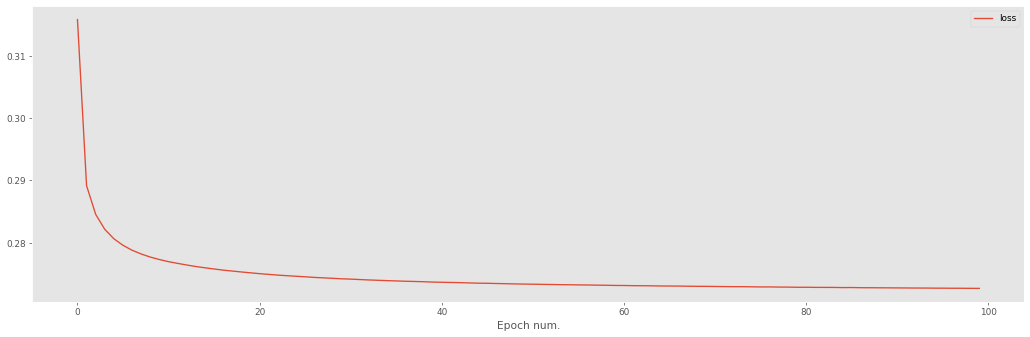

In [ ]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

El entrenamiento tiene muy buena pinta. Veamos cómo se codifican y descodifican algunos ejemplos del conjunto de entrenamiento.

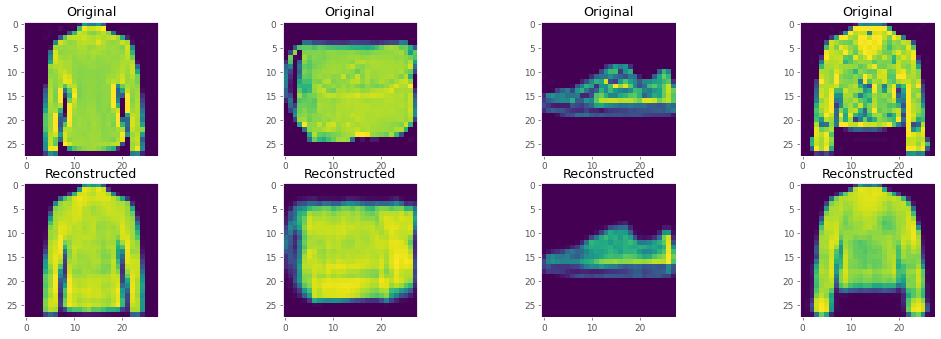

In [ ]:
n = 4
images = np.array(random.sample(list(x_train), n))

encoded = sae.encoder(images).numpy()
decoded = sae.decoder(encoded).numpy()
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title('Original')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i])
    plt.title('Reconstructed')

Y ahora, ¿qué pasará con los datos que teóricamente nunca ha visto?

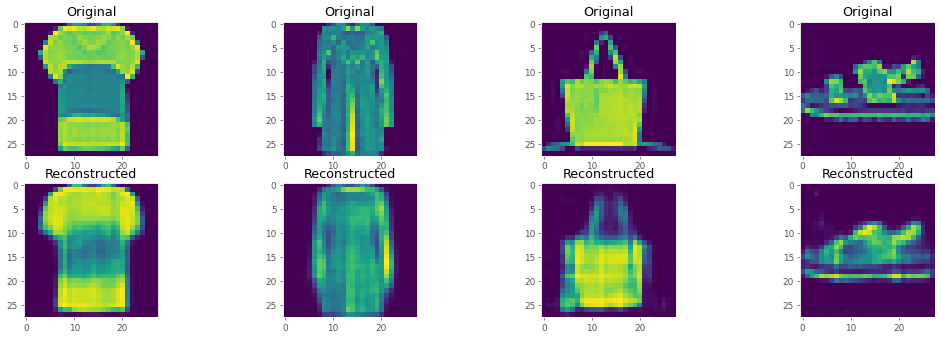

In [ ]:
images = np.array(random.sample(list(x_test), n))
encoded = sae.encoder(images).numpy()
decoded = sae.decoder(encoded).numpy()
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title('Original')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i])
    plt.title('Reconstructed')

Bastante bien, más borrosas y con menos detalles, pero no está mal. Así que pudimos comprimir las imágenes de 28x28=784 bytes (son monocromas) a 100 bytes, lo que supone algo más del 78% de ratio de compresión.

**Pregunta**: Si hemos dicho que los autoencoders no saben generalizar, por qué en este caso las imágenes del conjunto de test que nunca ha visto se reconstruyen bastante bien?

**Respuesta**: Debido a la similitud de todas las imágenes entre sí, el autoencoder es capaz de reconstruir las partes de las imágenes nuevas que sean iguales que las que vió durante el entrenamiento.

## Conclusiones

Hemos explorado el concepto de autoencoder apilado, es decir, el uso de varias capas en un autoencoder, y lo hemos aplicado al conjunto de datos MNIST de moda para reconstruir imágenes de prendas de vestir.

También hemos visualizado el rendimiento de reconstrucción del autocodificador apilado en varios ejemplos del conjunto de datos de prueba y hemos observado cómo el modelo aprendía a representar las imágenes en un espacio de menor dimensión. Además, la vinculación de pesos entre las capas codificadora y decodificadora puede reducir el número de parámetros del modelo y mejorar su rendimiento. Utilizando un autocodificador apilado de dos capas con una capa de cuello de botella en medio, pudimos lograr un buen rendimiento de reconstrucción en el conjunto de datos MNIST Fashion.

En general, hemos descubierto que los autocodificadores apilados pueden ser una potente herramienta para la reducción de la dimensionalidad y la reconstrucción de imágenes, y que pueden ser especialmente útiles para aplicaciones en las que la compresión de datos y la extracción de características son importantes, como en tareas de reconocimiento de imágenes y visión por ordenador.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>